<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Relationism_prediction_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<ipython-input-5-398fea2e9615>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endX'] = df1[qualifier_value_col].values[0]
<ipython-input-5-398fea2e9615>:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'endY'] = df1[qualifier_value_col].values[0]


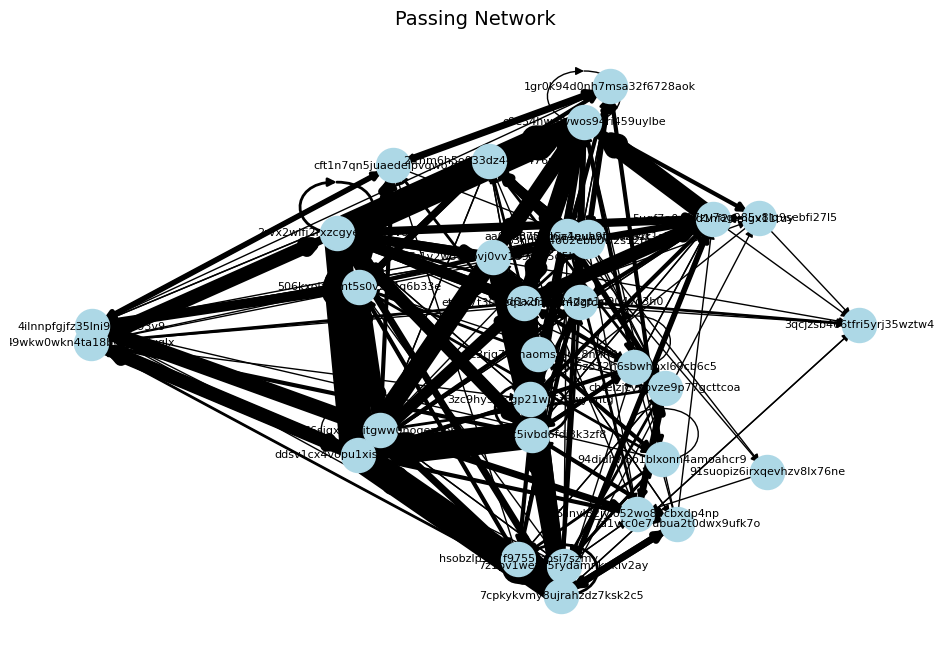

✅ Player metrics saved to: /content/drive/MyDrive/Recruitment/player_relationism_metrics.xlsx
✅ Team comparison saved to: /content/drive/MyDrive/Recruitment/team_relationism_comparison.xlsx


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load your dataset
file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'
df = pd.read_csv(file_path)

# STEP 1: Extract endX and endY from qualifier columns
type_cols = [col for col in df.columns if "qualifier/" in col and col.endswith("/qualifierId")]
df['endX'] = 0.0
df['endY'] = 0.0

for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        qualifier_id_col = type_cols[j]
        qualifier_value_col = qualifier_id_col.replace("/qualifierId", "/value")
        qualifier_id = df1[qualifier_id_col].values[0]

        if qualifier_id == 140:
            df.at[i, 'endX'] = df1[qualifier_value_col].values[0]
        elif qualifier_id == 141:
            df.at[i, 'endY'] = df1[qualifier_value_col].values[0]

# STEP 2: Filter successful passes and infer receivers
df = df.sort_values(by=['timeMin', 'timeSec'])
passes = df[(df['typeId'] == 1) & (df['outcome'] == 1)].copy()
passes['next_playerId'] = passes['playerId'].shift(-1)
passes['next_team'] = passes['contestantId'].shift(-1)

passes['receiverId'] = passes.apply(
    lambda row: row['next_playerId'] if row['contestantId'] == row['next_team'] else None, axis=1
)

passes = passes.dropna(subset=['receiverId'])
passes['receiverId'] = passes['receiverId'].astype(str)

# STEP 3: Pass counts and average positions
pass_counts = passes.groupby(['playerId', 'receiverId']).size().reset_index(name='pass_count')
player_positions = passes.groupby('playerId')[['x', 'y']].mean().reset_index()
relation_df = passes[['contestantId', 'playerName', 'receiverId']]

# STEP 4: Visualize Passing Network
G = nx.DiGraph()
for _, row in pass_counts.iterrows():
    G.add_edge(row['playerId'], row['receiverId'], weight=row['pass_count'])

pos = {row['playerId']: (row['x'], row['y']) for _, row in player_positions.iterrows()}

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=8)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, arrows=True, arrowstyle='-|>', arrowsize=12)
plt.title("Passing Network", fontsize=14)
plt.axis('off')
plt.show()

# STEP 5: Build Relationism Metrics
# 1. Top receiver ratio
pass_freq = relation_df.groupby(['playerName', 'receiverId']).size().reset_index(name='pass_count')
top_receiver = pass_freq.groupby('playerName')['pass_count'].max().reset_index(name='top_receiver_count')
total_by_player = pass_freq.groupby('playerName')['pass_count'].sum().reset_index(name='total_passes_freq')
top_receiver_ratio = pd.merge(top_receiver, total_by_player, on='playerName')
top_receiver_ratio['top_receiver_ratio'] = top_receiver_ratio['top_receiver_count'] / top_receiver_ratio['total_passes_freq']

# 2. Entropy
def calc_entropy(pass_counts):
    probs = pass_counts / pass_counts.sum()
    return -np.sum(probs * np.log2(probs))

entropy_df = pass_freq.groupby('playerName')['pass_count'].apply(calc_entropy).reset_index(name='receiver_entropy')

# 3. Closeness centrality
G_rel = nx.DiGraph()
for _, row in relation_df.iterrows():
    G_rel.add_edge(row['playerName'], row['receiverId'])

closeness_dict = nx.closeness_centrality(G_rel)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['playerName', 'pass_closeness'])

# 4. Avg pass chain length
chains = list(nx.weakly_connected_components(G_rel))
chain_lengths = {}
for component in chains:
    size = len(component)
    for player in component:
        chain_lengths[player] = chain_lengths.get(player, []) + [size]

avg_chain_df = pd.DataFrame([
    (player, np.mean(sizes)) for player, sizes in chain_lengths.items()
], columns=['playerName', 'avg_pass_chain_length'])

# 5. Base metrics (unique receivers / total passes)
relation_summary = relation_df.groupby(['contestantId', 'playerName'])['receiverId'].nunique().reset_index(name='unique_receivers')
total_passes = relation_df.groupby(['contestantId', 'playerName'])['receiverId'].count().reset_index(name='total_passes')
relationism_stats = pd.merge(relation_summary, total_passes, on=['contestantId', 'playerName'])
relationism_stats['relationism_score'] = relationism_stats['unique_receivers'] / relationism_stats['total_passes']

# Merge into final relationism dataframe
enhanced_relationism = relationism_stats.copy()
enhanced_relationism = enhanced_relationism.merge(top_receiver_ratio[['playerName', 'top_receiver_ratio']], on='playerName')
enhanced_relationism = enhanced_relationism.merge(entropy_df, on='playerName')
enhanced_relationism = enhanced_relationism.merge(closeness_df, on='playerName')
enhanced_relationism = enhanced_relationism.merge(avg_chain_df, on='playerName')

# STEP 6: Team comparison
team_comparison = enhanced_relationism.groupby('contestantId').agg({
    'relationism_score': 'mean',
    'top_receiver_ratio': 'mean',
    'receiver_entropy': 'mean',
    'pass_closeness': 'mean',
    'avg_pass_chain_length': 'mean',
    'total_passes': 'sum'
}).reset_index()

team_comparison.columns = [
    'Team (contestantId)',
    'Avg Relationism Score',
    'Avg Top Receiver Ratio',
    'Avg Receiver Entropy',
    'Avg Pass Closeness',
    'Avg Chain Length',
    'Total Passes'
]

# STEP 7: Save to Excel
player_output = '/content/drive/MyDrive/Recruitment/player_relationism_metrics.xlsx'
team_output = '/content/drive/MyDrive/Recruitment/team_relationism_comparison.xlsx'

enhanced_relationism.to_excel(player_output, index=False)
team_comparison.to_excel(team_output, index=False)

print("✅ Player metrics saved to:", player_output)
print("✅ Team comparison saved to:", team_output)


In [6]:
# STEP 1: Load the relationism metrics
import pandas as pd

player_data_path = '/content/drive/MyDrive/Recruitment/player_relationism_metrics.xlsx'
df = pd.read_excel(player_data_path)

df.head()


,contestantId,playerName,unique_receivers,total_passes,relationism_score,top_receiver_ratio,receiver_entropy,pass_closeness,avg_pass_chain_length
0,77tfx9me4aaqhzv78bmgsy9bg,A. Hansen,8,30,0.266667,0.333333,2.464945,0,30
1,77tfx9me4aaqhzv78bmgsy9bg,B. Nygren,10,40,0.250000,0.350000,2.742496,0,30
2,77tfx9me4aaqhzv78bmgsy9bg,C. Yirenkyi,6,13,0.461538,0.230769,2.507380,0,30
3,77tfx9me4aaqhzv78bmgsy9bg,D. Svensson,11,69,0.159420,0.231884,3.098343,0,30
4,77tfx9me4aaqhzv78bmgsy9bg,J. Tverskov,13,77,0.168831,0.233766,3.175942,0,30


In [7]:
# Binary classification target: 1 = Highly relational, 0 = Not
threshold = df['relationism_score'].median()
df['is_relational'] = (df['relationism_score'] > threshold).astype(int)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

# Features and target
features = ['total_passes', 'relationism_score', 'top_receiver_ratio', 'receiver_entropy',
             'avg_pass_chain_length']
X = df[features]
y = df['is_relational']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline with scaling + classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Cross-validation accuracy (5-fold)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"📊 Cross-Validation Accuracy: {cv_scores.mean():.2%} ± {cv_scores.std():.2%}")

# Predict and evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"🔍 ROC AUC Score: {roc_auc_score(y_test, y_proba):.2%}")


📊 Cross-Validation Accuracy: 90.00% ± 13.33%

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7

🔍 ROC AUC Score: 91.67%


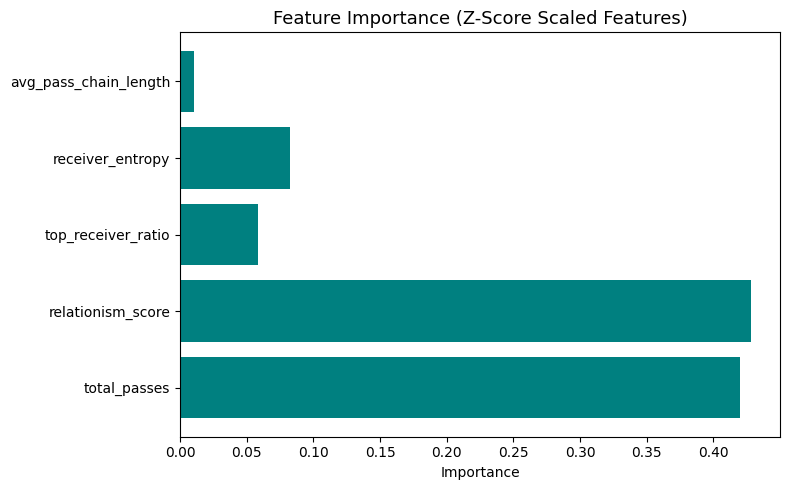

In [23]:
import matplotlib.pyplot as plt

# Extract model from pipeline
model = pipeline.named_steps['clf']

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='teal')
plt.title('Feature Importance (Z-Score Scaled Features)', fontsize=13)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



In [25]:
# STEP 5: Predict for a specific player (no pass_closeness)
def predict_player_relationism(player_name):
    player_row = df[df['playerName'].str.lower() == player_name.lower()]

    if player_row.empty:
        print(f"❌ Player '{player_name}' not found.")
        return

    X_player = player_row[features]
    prediction = pipeline.predict(X_player)[0]
    prob = pipeline.predict_proba(X_player)[0][prediction]

    label = 'Highly Relational' if prediction == 1 else 'Less Relational'

    print(f"\n🔍 Player: {player_name}")
    print(f"🧠 Prediction: {label}")
    print(f"📈 Confidence: {prob:.2%}")
    print(f"🔢 Features:\n{X_player.T}")
predict_player_relationism("A. Hansen")



🔍 Player: A. Hansen
🧠 Prediction: Less Relational
📈 Confidence: 98.50%
🔢 Features:
                               0
total_passes           30.000000
relationism_score       0.266667
top_receiver_ratio      0.333333
receiver_entropy        2.464945
avg_pass_chain_length  30.000000


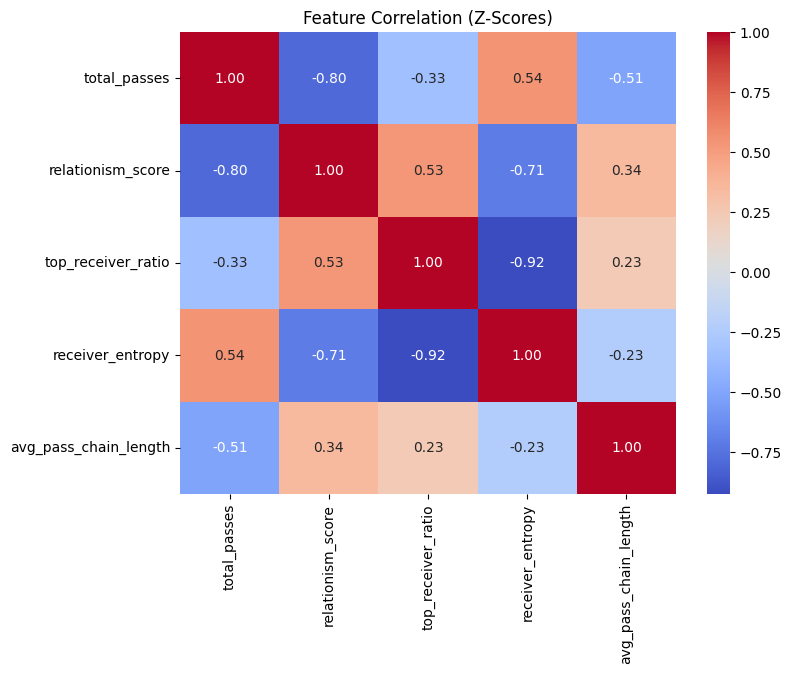

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap of z-scored features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
z_df = pd.DataFrame(X_scaled, columns=features)

plt.figure(figsize=(8, 6))
sns.heatmap(z_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation (Z-Scores)')
plt.show()
